### Plotting Benchmarks

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob

# --- 1. Define Paths and Find Files ---
METRICS_PATH = '/usr/local/google/home/tanjihui/Desktop/ipra-run/metrics'
# Use glob to find all files in the directory that end with '_metrics.csv'
all_files = glob.glob(os.path.join(METRICS_PATH, "*_metrics.csv"))

# --- 2. Load and Concatenate Data ---
# Create an empty list to hold the individual DataFrames
df_list = []

# Loop through the list of found files
for filename in all_files:
    # Read each CSV file and append its DataFrame to the list
    df_list.append(pd.read_csv(filename))

# Concatenate all DataFrames in the list into a single, master DataFrame
# ignore_index=True re-creates a clean index for the new combined DataFrame.
if df_list:
    df = pd.concat(df_list, ignore_index=True)
    print(f"Successfully loaded and concatenated {len(df_list)} metric files.")
else:
    print("Warning: No metric files found in the specified directory.")
    df = pd.DataFrame() # Create an empty DataFrame to avoid errors later

# --- 3. Process the Combined Data (Your original code) ---
# Ensure the 'Compiler' column is treated as a string
df['Compiler'] = df['Compiler'].astype(str)

# Filter to get only the rows with individual runs (1, 2, 3, etc.)
df_runs = df[pd.to_numeric(df['Run'], errors='coerce').notnull()].copy()
df_runs['Run'] = df_runs['Run'].astype(int)

# Create the 'TotalCPUTime_s' column by combining 'UserTime_s' and 'SysTime_s'
df_runs['TotalCPUTime_s'] = df_runs['UserTime_s'] + df_runs['SysTime_s']

# Create the "warm runs" DataFrame (excluding run 1)
warm_runs_df = df_runs[df_runs['Run'] > 1].copy()

# Set a consistent plot style for all graphs
plt.style.use('seaborn-v0_8-whitegrid')

Successfully loaded and concatenated 3 metric files.


In [20]:
warm_runs_df

,Compiler,Run,RealTime_s,UserTime_s,SysTime_s,TotalCPUTime_s
1,bootstrapped_clang,2,199.24,10202.01,538.90,10740.91
2,bootstrapped_clang,3,198.94,10200.94,537.26,10738.20
3,bootstrapped_clang,4,199.43,10236.70,538.43,10775.13
4,bootstrapped_clang,5,200.72,10262.88,540.45,10803.33
5,bootstrapped_clang,6,200.87,10271.68,539.16,10810.84
6,bootstrapped_clang,7,200.83,10272.27,540.77,10813.04
7,bootstrapped_clang,8,202.16,10319.42,543.09,10862.51
8,bootstrapped_clang,9,203.71,10296.98,545.91,10842.89
9,bootstrapped_clang,10,202.74,10296.74,547.06,10843.80
13,fdo_clang,2,155.27,7330.46,508.04,7838.50


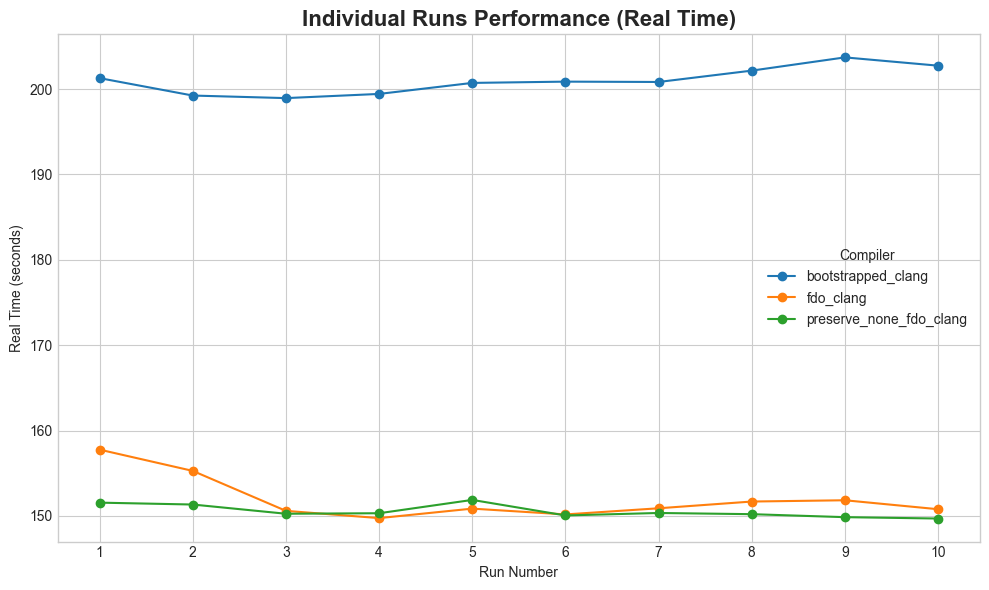

In [21]:
# --- 2. Generate Plots for Real Time ---

# 2a. Individual Runs - Real Time
pivot_real = df_runs.pivot(index='Run', columns='Compiler', values='RealTime_s')
fig, ax = plt.subplots(figsize=(10, 6))
pivot_real.plot(kind='line', marker='o', ax=ax)
ax.set_title('Individual Runs Performance (Real Time)', fontsize=16, fontweight='bold')
ax.set_ylabel('Real Time (seconds)')
ax.set_xlabel('Run Number')
ax.legend(title='Compiler')
ax.set_xticks(df_runs['Run'].unique())
plt.tight_layout()
plt.show()

/tmp/ipykernel_1074155/919862672.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(avg_real.index, rotation=0)


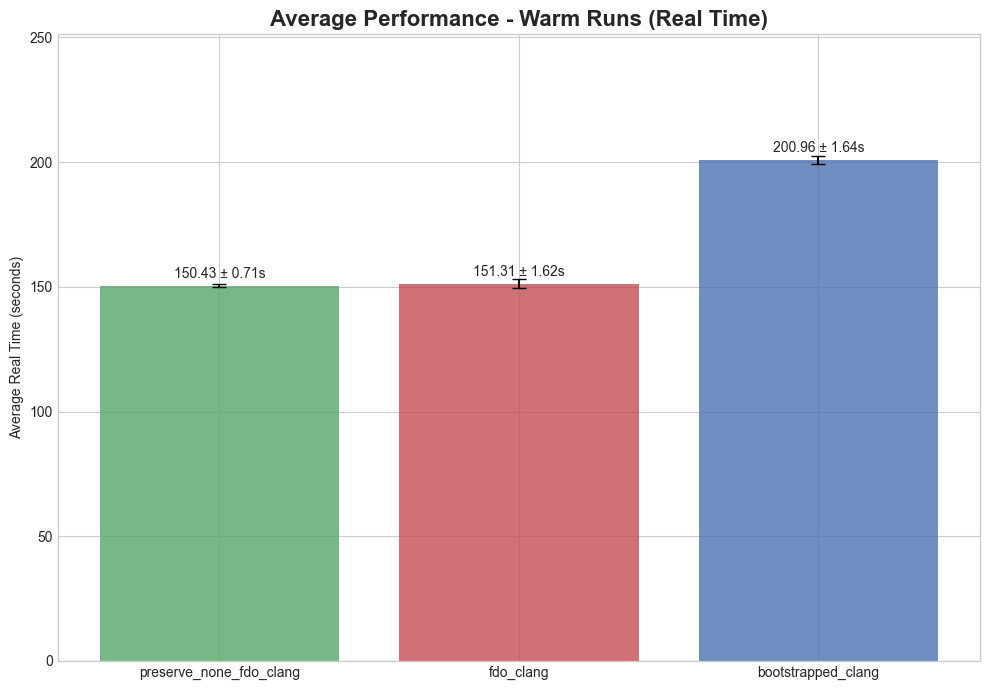

In [22]:
# 2b. Average Performance (Warm Runs) - Real Time
avg_real = warm_runs_df.groupby('Compiler')['RealTime_s'].mean().sort_values()
std_real = warm_runs_df.groupby('Compiler')['RealTime_s'].std().reindex(avg_real.index)
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(avg_real.index, avg_real, yerr=std_real, capsize=5,
              color=['#55a868', '#c44e52', '#4c72b0'], alpha=0.8)
ax.set_title('Average Performance - Warm Runs (Real Time)', fontsize=16, fontweight='bold')
ax.set_ylabel('Average Real Time (seconds)')
ax.set_xticklabels(avg_real.index, rotation=0)
ax.set_ylim(0, avg_real.max() * 1.25)
for i, bar in enumerate(bars):
    yval = bar.get_height()
    avg_val = avg_real.iloc[i]
    std_val = std_real.iloc[i]
    label = f'{avg_val:.2f} ± {std_val:.2f}s'
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 2, label, ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

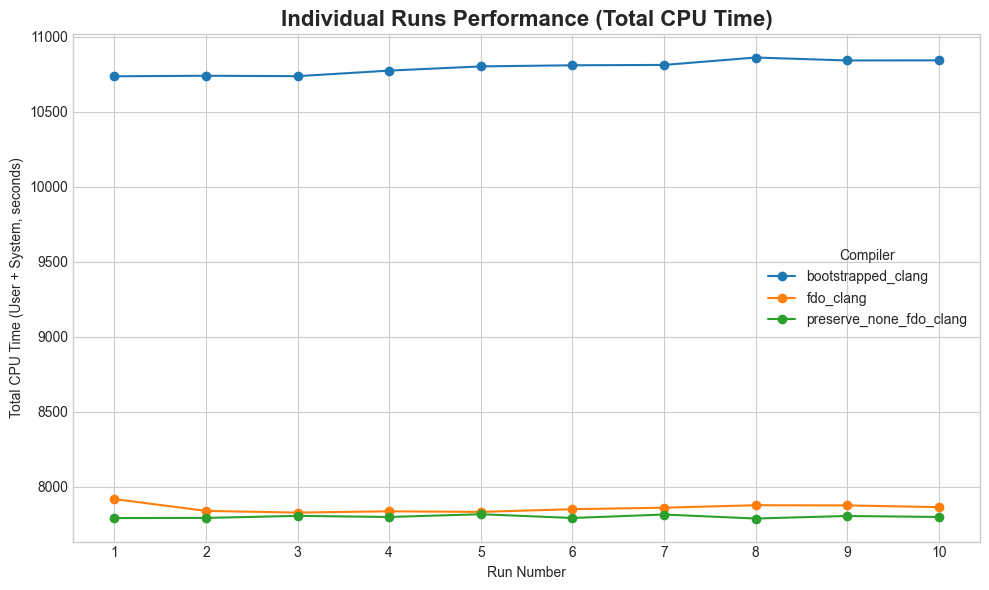

In [23]:
# --- 3. Generate Plots for Total CPU Time ---
# 3a. Individual Runs - Total CPU Time
pivot_cpu = df_runs.pivot(index='Run', columns='Compiler', values='TotalCPUTime_s')
fig, ax = plt.subplots(figsize=(10, 6))
pivot_cpu.plot(kind='line', marker='o', ax=ax)
ax.set_title('Individual Runs Performance (Total CPU Time)', fontsize=16, fontweight='bold')
ax.set_ylabel('Total CPU Time (User + System, seconds)')
ax.set_xlabel('Run Number')
ax.legend(title='Compiler')
ax.set_xticks(df_runs['Run'].unique())
plt.tight_layout()
plt.show()


/tmp/ipykernel_1074155/3212994367.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(avg_cpu.index, rotation=0)


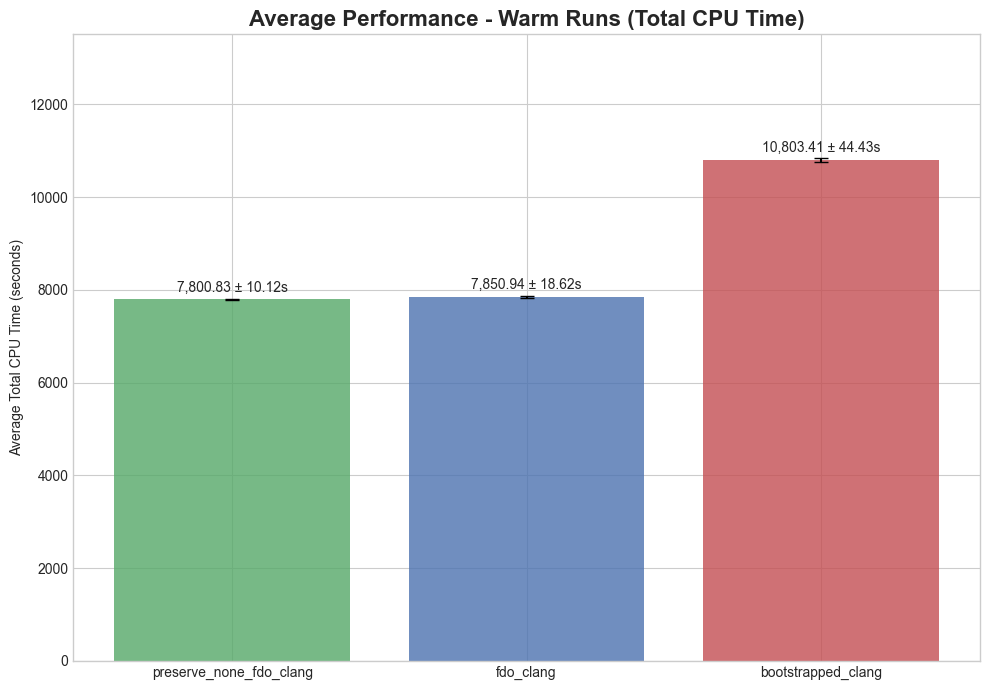

In [24]:
# 3b. Average Performance (Warm Runs) - Total CPU Time
avg_cpu = warm_runs_df.groupby('Compiler')['TotalCPUTime_s'].mean().sort_values()
std_cpu = warm_runs_df.groupby('Compiler')['TotalCPUTime_s'].std().reindex(avg_cpu.index)
fig, ax = plt.subplots(figsize=(10, 7))
bars = ax.bar(avg_cpu.index, avg_cpu, yerr=std_cpu, capsize=5,
              color=['#55a868', '#4c72b0', '#c44e52'], alpha=0.8)
ax.set_title('Average Performance - Warm Runs (Total CPU Time)', fontsize=16, fontweight='bold')
ax.set_ylabel('Average Total CPU Time (seconds)')
ax.set_xticklabels(avg_cpu.index, rotation=0)
ax.set_ylim(0, avg_cpu.max() * 1.25)
for i, bar in enumerate(bars):
    yval = bar.get_height()
    avg_val = avg_cpu.iloc[i]
    std_val = std_cpu.iloc[i]
    label = f'{avg_val:,.2f} ± {std_val:.2f}s'
    ax.text(bar.get_x() + bar.get_width()/2.0, yval + 100, label, ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

In [25]:
from scipy import stats

def perform_ttest(df, compiler1, compiler2, metric='RealTime_s', alpha=0.05):
    """
    Performs and interprets an independent two-sample t-test between two compilers.
    
    Args:
        df (pd.DataFrame): The DataFrame containing the benchmark data.
        compiler1 (str): The name of the baseline compiler.
        compiler2 (str): The name of the experimental compiler.
        metric (str): The performance metric column to compare (e.g., 'RealTime_s').
        alpha (float): The significance level for the test.
    """
    # --- 1. Extract Data ---
    # Isolate the performance metric for each of the two compilers.
    data1 = df[df['Compiler'] == compiler1][metric]
    data2 = df[df['Compiler'] == compiler2][metric]
    
    print(f"--- T-test for {compiler1} vs. {compiler2} on {metric} ---")
    print(f"Average for {compiler1}: {data1.mean():.2f}s")
    print(f"Average for {compiler2}: {data2.mean():.2f}s")
    
    # --- 2. Perform Welch's T-test ---
    # We use Welch's t-test (equal_var=False) as it's more robust and
    # does not assume the two groups have equal variance.
    t_statistic, p_value = stats.ttest_ind(data1, data2, equal_var=False, nan_policy='omit')
    
    print(f"T-statistic: {t_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # --- 3. Interpret the Results ---
    # The p-value tells us the probability of observing the data (or something
    # more extreme) if there were no real difference between the compilers.
    if p_value < alpha:
        print(f"Conclusion: The difference is statistically significant (p < {alpha}).")
        if data2.mean() < data1.mean():
            print(f"Result: '{compiler2}' shows a significant improvement (is faster) than '{compiler1}'.")
        else:
            print(f"Result: '{compiler2}' shows a significant regression (is slower) than '{compiler1}'.")
    else:
        print(f"Conclusion: The difference is not statistically significant (p >= {alpha}).")
        print("Result: We cannot conclude there is a meaningful performance difference between the two compilers.")
    print("-" * 60 + "\n")

In [26]:
# ==============================================================================
#                      Run the T-Tests on the "Warm Runs" Data
# ==============================================================================
# We use the 'warm_runs_df' to exclude the first run, which may be an outlier
# due to caching effects, providing a more stable comparison.

# --- Comparison 1: Standard FDO vs. IPRA-enabled FDO ---
perform_ttest(warm_runs_df, 'fdo_clang', 'preserve_none_fdo_clang', metric='RealTime_s')
perform_ttest(warm_runs_df, 'fdo_clang', 'preserve_none_fdo_clang', metric='TotalCPUTime_s')

--- T-test for fdo_clang vs. preserve_none_fdo_clang on RealTime_s ---
Average for fdo_clang: 151.31s
Average for preserve_none_fdo_clang: 150.43s
T-statistic: 1.4897
P-value: 0.1645
Conclusion: The difference is not statistically significant (p >= 0.05).
Result: We cannot conclude there is a meaningful performance difference between the two compilers.
------------------------------------------------------------

--- T-test for fdo_clang vs. preserve_none_fdo_clang on TotalCPUTime_s ---
Average for fdo_clang: 7850.94s
Average for preserve_none_fdo_clang: 7800.83s
T-statistic: 7.0947
P-value: 0.0000
Conclusion: The difference is statistically significant (p < 0.05).
Result: 'preserve_none_fdo_clang' shows a significant improvement (is faster) than 'fdo_clang'.
------------------------------------------------------------



In [27]:
# --- Comparison 2: ThinLTO FDO vs. IPRA-enabled ThinLTO FDO ---
perform_ttest(warm_runs_df, 'thinly_linked_fdo_clang', 'ipra_thinly_linked_fdo_clang', metric='RealTime_s')
perform_ttest(warm_runs_df, 'thinly_linked_fdo_clang', 'ipra_thinly_linked_fdo_clang', metric='TotalCPUTime_s')

--- T-test for thinly_linked_fdo_clang vs. ipra_thinly_linked_fdo_clang on RealTime_s ---
Average for thinly_linked_fdo_clang: nans
Average for ipra_thinly_linked_fdo_clang: nans
T-statistic: nan
P-value: nan
Conclusion: The difference is not statistically significant (p >= 0.05).
Result: We cannot conclude there is a meaningful performance difference between the two compilers.
------------------------------------------------------------

--- T-test for thinly_linked_fdo_clang vs. ipra_thinly_linked_fdo_clang on TotalCPUTime_s ---
Average for thinly_linked_fdo_clang: nans
Average for ipra_thinly_linked_fdo_clang: nans
T-statistic: nan
P-value: nan
Conclusion: The difference is not statistically significant (p >= 0.05).
Result: We cannot conclude there is a meaningful performance difference between the two compilers.
------------------------------------------------------------



/usr/local/google/home/tanjihui/Desktop/ipra-dev/metrics/venv/lib/python3.13/site-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)
